## Classification Task

Predict whether income exceeds $50K/yr based on Census Income Dataset

*census_income.csv - Census Income Dataset*

*census_income_details.names - Dataset description for Census data*

### Preprocessing

#####Imports

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [2]:
#importing census csv as pandas dataframe
census_df = pd.read_csv("/content/census_income.csv")

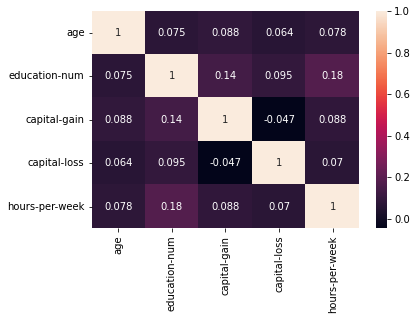

In [3]:
import seaborn as sn
sn.heatmap(census_df.corr(), annot=True)

##### F1 Score and Accuracy using Confusion matrix

In [4]:
def confusion_matrix(actual, predicted):
  classes = np.unique(actual) # extract the different classes
  matrix = np.zeros((len(classes), len(classes))) # initialize the confusion matrix with zeros
  for i in range(len(classes)):
    for j in range(len(classes)):
        matrix[i, j] = np.sum((actual == classes[i]) & (predicted == classes[j]))
  return matrix


def f1_score(actual, predicted):
  matrix = confusion_matrix(actual, predicted) 
  truePositive = matrix[0][0]
  falseNegative = matrix[0][1]
  falsePositive = matrix[1][0]
  precision = truePositive/(truePositive+falsePositive)
  recall = truePositive/(truePositive+falseNegative) 
  return 2*((precision*recall)/(precision+recall))


def model_accuracy(actual, predicted):
  matrix = confusion_matrix(actual, predicted)
  return (matrix[0][0]+matrix[1][1])/(matrix[0][0]+matrix[0][1]+matrix[1][0]+matrix[1][1]) 

##### Getting overview of data

In [5]:
# Getting a quick look at dataset 
census_df.head(100)

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,52,Self-emp-not-inc,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
1,31,Private,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
2,42,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K
3,37,Private,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0,0,80,United-States,>50K
4,30,State-gov,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,India,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,41,Private,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1977,65,United-States,>50K
96,28,?,Some-college,10,Married-civ-spouse,?,Wife,White,Female,0,1887,40,United-States,>50K
97,46,Private,Doctorate,16,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,60,United-States,>50K
98,35,Private,12th,8,Divorced,Craft-repair,Not-in-family,White,Male,0,0,50,United-States,>50K


In [6]:
# Getting basic stats
census_df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,17841.000000,17841.000000,17841.000000,17841.000000,17841.000000
mean,40.016759,10.484054,1841.885825,116.625357,41.802926
std,13.033215,2.599928,9867.217768,465.333031,12.184754
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,30.000000,9.000000,0.000000,0.000000,40.000000
50%,39.000000,10.000000,0.000000,0.000000,40.000000
75%,49.000000,13.000000,0.000000,0.000000,48.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


##### Removing null values

In [7]:
# Getting number of null values in each column
census_df.isna().sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [8]:
# Getting idea about which columns has null values is '?'
(census_df == "?").sum()

age                 0
workclass         820
education           0
education-num       0
marital-status      0
occupation        823
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    318
income              0
dtype: int64

In [9]:
# workclass, occupation and native-country has '?' values
# checking how many values are null with repect to other values
census_df["workclass"].value_counts()

Private             12161
Self-emp-not-inc     1455
Local-gov            1243
?                     820
Self-emp-inc          817
State-gov             741
Federal-gov           597
Without-pay             4
Never-worked            3
Name: workclass, dtype: int64

In [10]:
# workclass is categorical variable and number of mode values is quite large
# so instead of deleting we can replace it with mode values
census_df["workclass"].replace("?","Private",inplace=True)

In [11]:
census_df["native-country"].value_counts()

United-States         16085
?                       318
Mexico                  260
Philippines             115
Germany                  89
Canada                   66
India                    59
Puerto-Rico              56
Cuba                     53
England                  51
El-Salvador              46
Italy                    46
China                    46
South                    39
Japan                    38
Jamaica                  38
Poland                   37
Vietnam                  37
Dominican-Republic       36
Columbia                 31
Guatemala                29
Taiwan                   29
Haiti                    27
Iran                     27
France                   22
Portugal                 15
Peru                     14
Ecuador                  14
Greece                   13
Cambodia                 13
Hong                     12
Nicaragua                12
Ireland                  11
Yugoslavia               11
Trinadad&Tobago          10
Hungary             

In [12]:
# native-country is categorical variable and number of mode values is quite large
# so instead of deleting we can replace it with mode values
census_df["native-country"].replace("?","United-States",inplace=True)

In [13]:
census_df.occupation

0          Exec-managerial
1           Prof-specialty
2          Exec-managerial
3          Exec-managerial
4           Prof-specialty
               ...        
17836                    ?
17837    Handlers-cleaners
17838        Other-service
17839      Priv-house-serv
17840        Other-service
Name: occupation, Length: 17841, dtype: object

In [14]:
census_df = census_df[census_df.occupation != "?"]

In [15]:
# Sanity check to see all null values are removed
(census_df == "?").sum()

age               0
workclass         0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

##### Dropping unnecessary columns 

In [16]:
# dropping edu since edu-num is present in data frame
col_to_drop = ["education",
  "workclass",
  "occupation",
  "race",
  "sex",
  "relationship",
  "native-country",
  "marital-status"
  ]
census_df = census_df.drop(col_to_drop,1) 

##### Convering catagorical variable to numeric form

###### One hot encoding

In [17]:
columns_to_encode = [
  # "workclass",
  # "occupation",
  # "race",
  # "sex",
  # "relationship",
  # "native-country",
  # "marital-status"
]
census_df = pd.get_dummies(census_df, columns = columns_to_encode)

###### Label Encoding

In [18]:
label_encoder = LabelEncoder()

In [19]:
label_encode_income = census_df["income"]

In [20]:
census_df.drop("income",1,inplace=True)

In [21]:
census_df["income"] = label_encoder.fit_transform(label_encode_income)

In [22]:
census_df["income"].value_counts()

0    9368
1    7650
Name: income, dtype: int64

In [23]:
census_df.head()

,age,education-num,capital-gain,capital-loss,hours-per-week,income
0,52,9,0,0,45,1
1,31,14,14084,0,50,1
2,42,13,5178,0,40,1
3,37,10,0,0,80,1
4,30,13,0,0,40,1


##### Standardisation & Normilization

###### Standardisation

In [24]:
def Standardizer(col):
  mean = np.mean(col)
  std = np.mean(col)
  return [(x - mean)/std for x in col]

In [25]:
census_df["capital-gain"] = Standardizer(census_df["capital-gain"])
census_df["capital-loss"] = Standardizer(census_df["capital-loss"])

###### Normilization

In [26]:
def Normalization(col):    
  min = col.min()
  max = col.max()
  return [(x - min)/(max - min) for x in col]

In [27]:
census_df["capital-gain"] = Normalization(census_df["capital-gain"])
census_df["capital-loss"] = Normalization(census_df["capital-loss"])
census_df["education-num"] = Normalization(census_df["education-num"])
census_df["age"] = Normalization(census_df["age"])

##### Removing duplicated rows

In [28]:
# checking duplicate rows
# serial no. should be removed before checking duplicates (we don't have any such column)
# Getting index of duplicated rows 
census_df.index[census_df.duplicated()]

Int64Index([   81,    84,   108,   140,   145,   150,   151,   164,   166,
              189,
            ...
            17826, 17827, 17829, 17830, 17831, 17832, 17833, 17834, 17837,
            17838],
           dtype='int64', length=8862)

In [29]:
# Getting count of duplicate rows
census_df.duplicated().sum()

8862

In [30]:
# Removing duplicate rows
census_df.drop(axis="rows", labels=census_df.index[census_df.duplicated()], inplace=True)

In [31]:
# Getting count of duplicate rows again for sanity check 
census_df.duplicated().sum()

0

##### Splitting dataset

In [32]:
# Shuffle data well to take out random data for training and testing
shuffled_df = census_df.sample(frac=1, random_state=2)
# Define size of training data
train_size = (int)(0.8*len(census_df))
# Make separate df for training and testing
train_set = shuffled_df[:train_size]
test_set = shuffled_df[train_size:]
print(len(test_set), len(train_set))

1632 6524


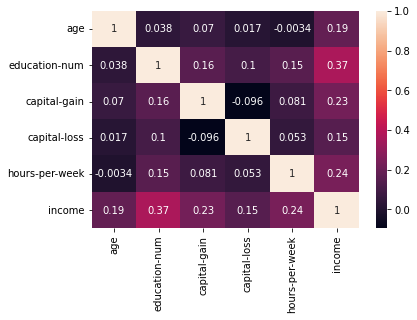

In [33]:
import seaborn as sn
sn.heatmap(census_df.corr(), annot=True)

### Classification Model Classes

#### Logistic Regression Gradient Ascent Class

In [34]:
class logestic_regression_gradient_ascent:
  def __init__(self,  iterations=2000, learning_rate=0.000005):
    self.learning_rate = learning_rate
    self.iterations = iterations

  # P(y=1 | X;W)
  def sigmoid(self, x, W):
      return (1/(1+np.exp(-W@x)))

  # Decides which class X(entry) belongs to using sigmoid
  def P(self, X, W):#y=1
    return np.array([1 if (self.sigmoid(x, self.W)> 0.5) else 0 for x in X])

  # Learning Algorithm
  def train(self, X_train, Y_train):
    self.X_train = X_train
    self.Y_train = Y_train
    X_train = np.c_[X_train, np.ones(X_train.shape[0])]
    np.random.seed(2)
    self.W = np.random.uniform(high = 1, low = -1, size = X_train.shape[1])
    for _ in range(self.iterations):
      # Θ(new) = Θ(old) - μ*∂J/∂Θ
      dW = X_train.T@(Y_train-self.P(X_train, self.W))
      self.W = self.W + self.learning_rate*dW
  
  # Inferance Algorithm 
  def predict(self, X_test):
    self.X_test = X_test
    X_test = np.c_[X_test, np.ones(X_test.shape[0])]
    self.Y_pred = self.P(X_test, self.W)
    return self.Y_pred

  # calculated the accuracy of model using confusion matrix
  def accuracy(self, Y_test):
    return model_accuracy(Y_test, self.Y_pred)

  # calculated the accuracy of model using confusion matrix
  def f1_score(self, Y_test):
    return f1_score(Y_test, self.Y_pred)

#### Logistic Regression Newton's Method Class

In [35]:
class logestic_regression_newtons_method:
  def __init__(self, iterations=1):
    self.iterations = iterations

  # P(y=1 | X;W)
  def sigmoid(self, X, Y=1):
    if Y == 1:
      return 1/(1+np.exp(-(X@self.W)))
    else:
      return 1/(1+np.exp((X@self.W)))
  
  # Learning Algorithm
  def train(self, X_train, Y_train):
    self.X_train = X_train
    self.Y_train = Y_train
    self.W = np.zeros((X_train.shape[1]))
    for _ in range(self.iterations):
      # Hessian Matrix
      H = -X_train.T @ np.diag(self.sigmoid(X_train)*(1-self.sigmoid(X_train))) @ X_train
      # Hessian Inverse
      HInv = np.linalg.inv(H)
      # Differential of cost functionn
      dW = X_train.T @ (Y_train-self.sigmoid(X_train))
      # Updated Weight
      self.W = self.W - HInv @ dW 

  # Inferance Algorithm
  def predict(self, X_test):
    self.Y_pred = np.zeros(len(X_test))
    X_test = np.array(X_test)
    # for row in range(len(X_test)):
    self.P0 = self.sigmoid(X_test, Y=0) # probability of X[row] to be class 0
    self.P1 = self.sigmoid(X_test) # probability of X[row] to be class 1
    # comparing the prob and getting the predicted class
    for i in range(len(X_test)):
      if self.P0[i]>self.P1[i]:
        self.Y_pred[i] = 0
      else:
        self.Y_pred[i] = 1
    # self.Y_pred = 1 if(p1>p0) else 0
    # print(p0,p1)
    return self.Y_pred

  # calculated the accuracy of model using confusion matrix
  def accuracy(self, Y_test):
    return model_accuracy(Y_test, self.Y_pred)

  # calculated the accuracy of model using confusion matrix
  def f1_score(self, Y_test):
    return f1_score(Y_test, self.Y_pred)

#### Naive Bayes Model Class

In [36]:
class NaiveBayes():
# calculates gaussian probability given and value and a class  
  def probability(self, X, row, col, c):
    return (1/self.stds[c][col]*np.sqrt(2*3.14)) * np.exp(-((X[row][col]-self.means[c][col])**2)/2*self.stds[c][col]**2)

  # Learning Algorithm
  def train(self, X_train, Y_train):
    # finding mean for each feature
    self.means = np.array(X_train.groupby(Y_train).apply(np.mean))
    # finding standard deviation for each feature
    self.stds = np.array(X_train.groupby(Y_train).apply(np.std)) 
    # calculating probability of each class
    self.pc = [len(train_set[train_set["income"] == 0])/len(train_set), len(train_set[train_set["income"] == 1])/len(train_set)]
    X_train = np.array(X_train)

  # Inferance Algorithm
  def predict(self, X_test):
    self.Y_pred = []
    X_test = np.array(X_test)
    for row in range(len(X_test)):
      p0 = self.pc[0] # probability of X[row] to be class 0
      p1 = self.pc[1] # probability of X[row] to be class 1
      # calculating prob of each feature to be in given class
      # by considering them independent 
      # and hence by multiplying their probabilities together  
      for col in range(X_test.shape[1]):
        p0 *= self.probability(X_test, row, col, 0)
        p1 *= self.probability(X_test, row, col, 1)
      # comparing the prob and getting the predicted class
      self.Y_pred.append(1 if(p1>p0) else 0)
    return self.Y_pred

  # calculated the accuracy of model using confusion matrix
  def accuracy(self, Y_test):
    return model_accuracy(Y_test, self.Y_pred)

  # calculated the accuracy of model using confusion matrix
  def f1_score(self, Y_test):
    return f1_score(Y_test, self.Y_pred)

### Models

###### Getting Training and Testing data

In [ ]:
test_set.columns

In [46]:
Y_train = np.array(train_set["income"])
Y_test = np.array(test_set["income"])
drop = ["income",
        # 'age',
        'education-num',
        'capital-gain', 'capital-loss', 'hours-per-week'
      #  , 'workclass_Federal-gov', 'workclass_Local-gov',
      #  'workclass_Private', 'workclass_Self-emp-inc',
      #  'workclass_Self-emp-not-inc', 'workclass_State-gov',
      #  'workclass_Without-pay', 'occupation_Adm-clerical',
      #  'occupation_Armed-Forces', 'occupation_Craft-repair',
      #  'occupation_Exec-managerial', 'occupation_Farming-fishing',
      #  'occupation_Handlers-cleaners', 'occupation_Machine-op-inspct',
      #  'occupation_Other-service', 'occupation_Priv-house-serv',
      #  'occupation_Prof-specialty', 'occupation_Protective-serv',
      #  'occupation_Sales', 'occupation_Tech-support',
      #  'occupation_Transport-moving', 'race_Amer-Indian-Eskimo',
      #  'race_Asian-Pac-Islander', 'race_Black', 'race_Other', 'race_White',
      #  'sex_Female', 'sex_Male', 'relationship_Husband',
      #  'relationship_Not-in-family', 'relationship_Other-relative',
      #  'relationship_Own-child', 'relationship_Unmarried', 'relationship_Wife',
      #  'native-country_Cambodia', 'native-country_Canada',
      #  'native-country_China', 'native-country_Columbia',
      #  'native-country_Cuba', 'native-country_Dominican-Republic',
      #  'native-country_Ecuador', 'native-country_El-Salvador',
      #  'native-country_England', 'native-country_France',
      #  'native-country_Germany', 'native-country_Greece',
      #  'native-country_Guatemala', 'native-country_Haiti',
      #  'native-country_Honduras', 'native-country_Hong',
      #  'native-country_Hungary', 'native-country_India', 'native-country_Iran',
      #  'native-country_Ireland', 'native-country_Italy',
      #  'native-country_Jamaica', 'native-country_Japan', 'native-country_Laos',
      #  'native-country_Mexico', 'native-country_Nicaragua',
      #  'native-country_Peru', 'native-country_Philippines',
      #  'native-country_Poland', 'native-country_Portugal',
      #  'native-country_Puerto-Rico', 'native-country_Scotland',
      #  'native-country_South', 'native-country_Taiwan',
      #  'native-country_Thailand', 'native-country_Trinadad&Tobago',
      #  'native-country_United-States', 'native-country_Vietnam',
      #  'native-country_Yugoslavia', 'marital-status_Divorced',
      #  'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
      #  'marital-status_Married-spouse-absent', 'marital-status_Never-married',
      #  'marital-status_Separated', 'marital-status_Widowed'
]
X_log_train = np.array(train_set.drop(axis=1, labels=drop))
X_log_test = np.array(test_set.drop(axis=1, labels=drop))

X_nv_train = train_set.drop(axis=1, labels=drop)
X_nv_test = test_set.drop(axis=1, labels=drop)

###### Logistic Regression Gradient Ascent Model

In [ ]:
logestic_regression_gradient_ascent_model = logestic_regression_gradient_ascent(500, 0.000005)
# Training Model
logestic_regression_gradient_ascent_model.train(X_log_train, Y_train)
# Inferance Algorithm
logestic_regression_gradient_ascent_model.predict(X_log_test)
# Checking Accuracy
print("Logistic Regression Gradient Ascent Model")
print("accuracy   : ",logestic_regression_gradient_ascent_model.accuracy(Y_test))
print("f1_score   : ",logestic_regression_gradient_ascent_model.f1_score(Y_test))

###### Logistic Regression Newton's Method Model 

In [ ]:
logestic_regression_newtons_method_model = logestic_regression_newtons_method();
# Learning Algorithm
logestic_regression_newtons_method_model.train(X_log_train, Y_train)
# Inferance Algorithm
logestic_regression_newtons_method_model.predict(X_log_test)
# Checking Accuracy
print("Logistic Regression Newton's Method Model")
print("accuracy   : ",logestic_regression_newtons_method_model.accuracy(Y_test))
print("f1_score   : ",logestic_regression_newtons_method_model.f1_score(Y_test))

###### Naive Bayes Model

In [ ]:
NaiveBayesModel = NaiveBayes()
# Learning Algorithm
NaiveBayesModel.train(X_nv_train, Y_train)
# Inferance Algorithm
NaiveBayesModel.predict(X_nv_test)
# Checking Accuracy
print("Naive Bayes Model")
print("accuracy   : ",NaiveBayesModel.accuracy(Y_test))
print("f1_score   : ",NaiveBayesModel.f1_score(Y_test))

In [ ]:
print("Naive Bayes Model")
print("accuracy   : 72.372262773493104")
print("f1_score   : 0.6434937611408199")